In [2]:
!pip install pandas_ta
!pip install ta

import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as pdta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=dec0e9b833f066f34c6984c3421c82966898400c9a9cba9ea8beab05953ccf03
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b50354aed139d71864e0a3d36adc805c3e0b09f343ed1803aa19cbfd647a0369
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [251]:
ticker = 'AAPL'
df = yf.download(ticker, start = '2012-03-11',end = '2022-07-10')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,19.606428,19.714287,19.535713,19.714287,16.648226,407282400
2012-03-13,19.912144,20.292143,19.848213,20.289286,17.133801,690855200
2012-03-14,20.644644,21.240000,20.549999,21.056429,17.781637,1418844000
2012-03-15,21.414642,21.428928,20.662500,20.912857,17.660387,1159718000
2012-03-16,20.882856,21.042856,20.642857,20.913214,17.660686,825487600


In [252]:
print(len(df))

2599


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2599 entries, 2012-03-12 to 2022-07-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2599 non-null   float64
 1   High       2599 non-null   float64
 2   Low        2599 non-null   float64
 3   Close      2599 non-null   float64
 4   Adj Close  2599 non-null   float64
 5   Volume     2599 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 142.1 KB


In [294]:
# Instead of predicting prices, we predict % change in prices

df["target"] = df["Adj Close"].shift(-1)
# df["target"] = df['Adj Close'].shift(-1) - df['Adj Close']
df["target"] = df["Adj Close"].pct_change().shift(-1)  # Percentage change next day
# df["target"] = np.where(df["target"] > 0, 1, 0)
# df.head()

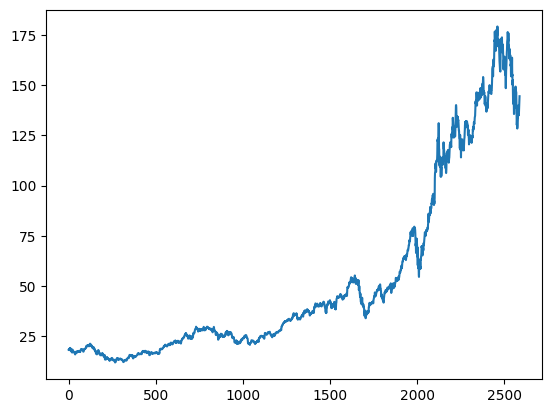

In [295]:
plt.plot(df.index, df['Adj Close'], label='Close Price')
plt.show()

<Axes: xlabel='target', ylabel='count'>

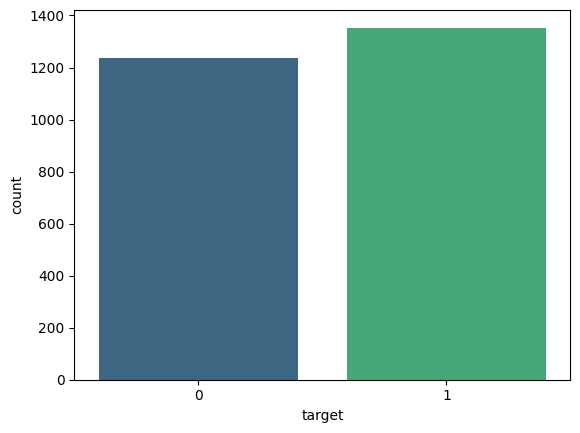

In [297]:
# plt.plot(df.index,df.target)
# plt.axhline(y=0,color="black")
# plt.grid(True)
sns.countplot(x='target', data=df, palette='viridis')


Feature Engineering

In [296]:
def check_corr(col):
  print(f"Correlation with {col} is : {df.target.corr(df[col])}")

# print(np.log1p(df["Adj Close"][1]/df["Adj Close"][0]))

In [298]:
# Adding features
df["max_movement"] = (df["High"]-df["Low"]).pct_change()
df["price_change"] = (df["Adj Close"]-df["Open"]).pct_change()
df["vol_change"] = df.Volume.pct_change()
df["log_returns"] = np.log1p(df["Adj Close"]/df["Adj Close"].shift(1))

In [299]:
# Volatility indicators
import ta
window = 10

df["rolling_std"] = df["Adj Close"].rolling(window=window).std()
df["ATR"] = ta.volatility.AverageTrueRange(df.High,df.Low,df["Adj Close"], window = window).average_true_range()
df["BollingerBands"] = ta.volatility.BollingerBands(df["Adj Close"], window = window).bollinger_mavg()
df["KC_Band"] = ta.volatility.keltner_channel_hband_indicator(df.High,df.Low,df["Adj Close"],window = window)

In [300]:
# Momentum Indicators
df['RSI']= ta.momentum.rsi(df["Adj Close"], window = window)
df['ROC'] = ta.momentum.roc(df["Adj Close"], window = window)
df['Stochastic Oscillator'] = ta.momentum.stoch(df.High,df.Low,df["Adj Close"],window = window)

In [301]:
# Averages (Overlaps)

df['SMA_W'] = pdta.sma(df["Adj Close"],length=window)
df['EMA_W'] = pdta.ema(df["Adj Close"],length=window)
df['EMA_W/2'] = pdta.ema(df["Adj Close"],length=window)
df["ohlc4"] = (df.High + df.Low + df.Open + df["Adj Close"])/4
df['vwap'] = ta.volume.VolumeWeightedAveragePrice(df.High,df.Low,df["Adj Close"],df.Volume,window = window).volume_weighted_average_price()

In [302]:
df.head()

,Open,High,Low,Adj Close,Volume,max_movement,price_change,vol_change,log_returns,rolling_std,...,KC_Band,RSI,ROC,Stochastic Oscillator,SMA_W,EMA_W,EMA_W/2,ohlc4,vwap,target
0,21.421070,21.683929,21.259287,18.306416,595742000,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.667675,NaN,1
1,21.649286,22.010000,21.645000,18.532614,607129600,-0.140454,0.000648,0.019115,0.699306,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.959225,NaN,1
2,22.084999,22.194643,21.796785,18.627321,655460400,0.090022,0.109413,0.079605,0.695699,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.175937,NaN,0
3,21.885000,22.020000,21.686787,18.393272,608238400,-0.162480,0.009848,-0.072044,0.686845,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.996265,NaN,0
4,21.741785,21.805714,21.355000,18.082333,731038000,0.352627,0.048035,0.201894,0.684659,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.746208,NaN,1


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2599 entries, 2012-03-12 to 2022-07-08
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   2599 non-null   float64
 1   High                   2599 non-null   float64
 2   Low                    2599 non-null   float64
 3   Close                  2599 non-null   float64
 4   Adj Close              2599 non-null   float64
 5   Volume                 2599 non-null   int64  
 6   target                 2598 non-null   float64
 7   max_movement           2598 non-null   float64
 8   price_change           2598 non-null   float64
 9   vol_change             2598 non-null   float64
 10  log_returns            2598 non-null   float64
 11  rolling_std            2590 non-null   float64
 12  ATR                    2599 non-null   float64
 13  BollingerBands         2590 non-null   float64
 14  KC_Band                2599 non-null  

In [264]:
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(columns=["Date","Close"],inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,target,max_movement,price_change,vol_change,log_returns,...,BollingerBands,KC_Band,RSI,ROC,Stochastic Oscillator,SMA_W,EMA_W,EMA_W/2,ohlc4,vwap
0,21.421070,21.683929,21.259287,18.306416,595742000,18.532614,0.606754,-0.102224,0.383873,0.702274,...,17.917172,0.0,79.555085,9.960159,-80.093336,17.917172,17.852273,17.852273,20.667675,20.028679
1,21.649286,22.010000,21.645000,18.532614,607129600,18.627321,-0.140454,0.000648,0.019115,0.699306,...,18.057053,0.0,82.540064,8.164057,-138.176994,18.057053,17.975971,17.975971,20.959225,20.162396
2,22.084999,22.194643,21.796785,18.627321,655460400,18.393272,0.090022,0.109413,0.079605,0.695699,...,18.141621,0.0,83.650546,4.755940,-129.884843,18.141621,18.094399,18.094399,21.175937,20.286191
3,21.885000,22.020000,21.686787,18.393272,608238400,18.082333,-0.162480,0.009848,-0.072044,0.686845,...,18.214910,0.0,71.213648,4.149883,-144.967385,18.214910,18.148739,18.148739,20.996265,20.387490
4,21.741785,21.805714,21.355000,18.082333,731038000,18.657776,0.352627,0.048035,0.201894,0.684659,...,18.257075,0.0,58.397323,2.387484,-255.384917,18.257075,18.136665,18.136665,20.746208,20.466013


In [265]:
print(len(df))

2588


Standardization & Train-Test Split

In [266]:
columns_to_standardize = ["Open","High","Low","Adj Close","Volume","Stochastic Oscillator","EMA_W","EMA_W/2","SMA_W","ohlc4","ohlc4"]
# columns_to_standardize = ["Open","High","Low","Adj Close","Volume"]

In [267]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# dropping target var
y = df["target"].to_numpy()
df.drop(columns = ["target"], inplace = True)

# constructing training and testing set
train_size = round(0.80 * len(df))
df_train = df[:train_size]
df_test = df[train_size:]

# standardizing
scaler = StandardScaler()
df_train[columns_to_standardize] = scaler.fit_transform(df_train[columns_to_standardize])
df_test[columns_to_standardize] = scaler.transform(df_test[columns_to_standardize])

In [268]:
new_df = pd.concat([df_train,df_test], axis = 0)
new_df.tail()

,Open,High,Low,Adj Close,Volume,max_movement,price_change,vol_change,log_returns,rolling_std,...,BollingerBands,KC_Band,RSI,ROC,Stochastic Oscillator,SMA_W,EMA_W,EMA_W/2,ohlc4,vwap
2583,6.570959,6.531520,6.431240,6.483025,-0.737979,0.149998,-42.620522,0.493975,0.684093,3.776329,...,135.095432,0.0,44.758105,0.952544,1.385085,6.575379,6.658622,6.658622,6.505739,135.625572
2584,6.493625,6.573763,6.553212,6.620373,-0.900024,-0.265218,-1.531175,-0.282050,0.701197,3.001741,...,135.971497,0.0,49.278805,6.819946,1.530027,6.631180,6.668442,6.668442,6.561920,136.513560
2585,6.604193,6.735799,6.635172,6.783821,-0.886659,0.384622,0.737094,0.032402,0.702568,2.349999,...,136.959167,0.0,54.231280,7.601105,1.641234,6.694089,6.706568,6.706568,6.691808,137.778420
2586,6.832999,6.894052,6.902996,6.868343,-0.882534,-0.350430,-1.094038,0.009686,0.697939,2.468460,...,137.655475,0.0,56.662589,5.188786,1.727313,6.738440,6.753323,6.753323,6.876016,138.516635
2587,6.956987,7.047262,7.044975,7.081513,-0.927877,0.075662,-7.530079,-0.105457,0.705076,2.881213,...,138.741913,1.0,62.277995,8.127088,1.875389,6.807640,6.830823,6.830823,7.034373,139.405179


In [269]:
X = new_df.to_numpy()

In [277]:
# creating data-points
back = 30
X_new = []
# for i in range(back+1,len(X)):
#     instance = X[i - back : i]
#     X_new.append(instance)
X_new = np.array([new_df[i-back:i].copy() for i in range(back,len(new_df))])

X_new = np.array(X_new)
y_new = np.array(y[back:])

In [283]:
train_size = round(0.80 * len(df))
X_train,X_test = X_new[:train_size],X_new[train_size:]
y_train,y_test = y_new[:train_size],y_new[train_size:]

In [284]:
y_train.shape

(2070,)

In [285]:
X_train.shape

(2070, 30, 21)

In [286]:
X_test.shape

(488, 30, 21)

In [287]:
y_test.shape

(488,)

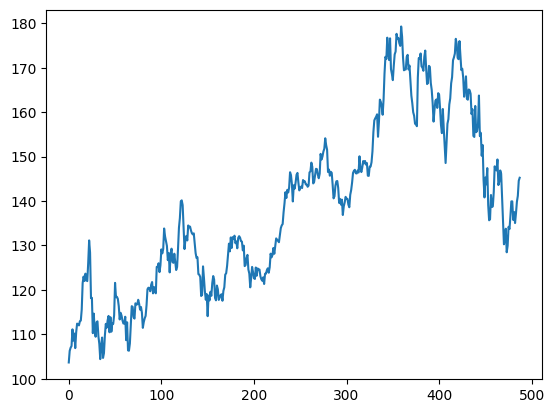

In [288]:
plt.plot(y_test)

Models

In [187]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         # self.activation = nn.Linear(hidden_size,output_size)  # Equivalent to 'linear' activation in Keras

#     def forward(self, x):
#         # LSTM layer
#         lstm_out, _ = self.lstm(x)
#         # We take the last output from the LSTM
#         lstm_out = lstm_out[:, -1, :]
#         # Dense layer
#         output = self.fc(lstm_out)
#         # Linear activation
#         # output = self.activation(output)
#         return output


In [188]:
# input_size = 21 # Number of input features (e.g., a single feature for time series)
# hidden_size = 150  # Number of LSTM units
# num_layers = 1  # Number of LSTM layers
# output_size = 1  # Output size (e.g., predicting a single value)
# learning_rate = 0.001

# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [189]:
# num_epochs = 30
# batch_size = 64

# # Assuming X_train and y_train are your training data as tensors
# train_dataset = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(np.array(y_train)))
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# train_loss = []
# for epoch in range(num_epochs):
#     for X_batch, y_batch in train_loader:
#         # Forward pass
#         X_batch = X_batch.to(torch.float32)
#         y_batch = y_batch.to(torch.float32)
#         # print(X_batch.shape)
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     if (epoch+1) % 1 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#         train_loss.append(loss.item())


In [290]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

lstm_input = Input(shape=(30, 21), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dropout(0.2)(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 763.5576 - val_loss: 3900.9456
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 349.7783 - val_loss: 3028.9792
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 221.3953 - val_loss: 2617.6821
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 154.6124 - val_loss: 2359.0806
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 130.5682 - val_loss: 2097.6294
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 88.0810 - val_loss: 1879.6333
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 66.7568 - val_loss: 1690.7661
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 44.0050 - val_loss: 1545.9753
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 35.3956 - val_loss: 1414.9668
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 28.6388 - val_loss: 1322.1060
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 19.5995 - val_loss: 1264.0739
Epoch 12/30

In [45]:
# plt.plot(train_loss)

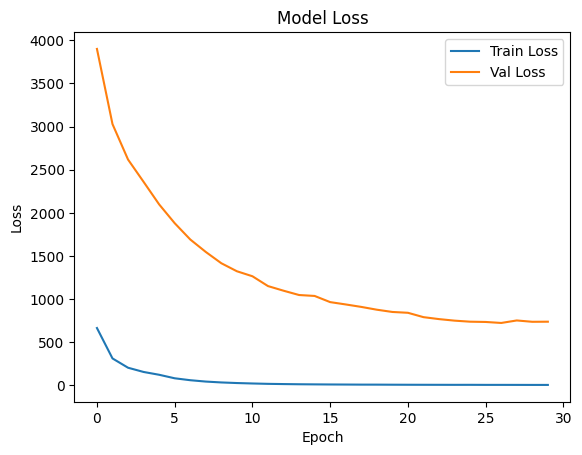

In [291]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [292]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R² Score: {r2}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Mean Squared Error (MSE): 10698.263540435277
R² Score: -28.057254689065587


In [293]:
r2 = r2_score(y_train, model.predict(X_train))
print(f'R² Score: {r2}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
R² Score: 0.7503415956934628


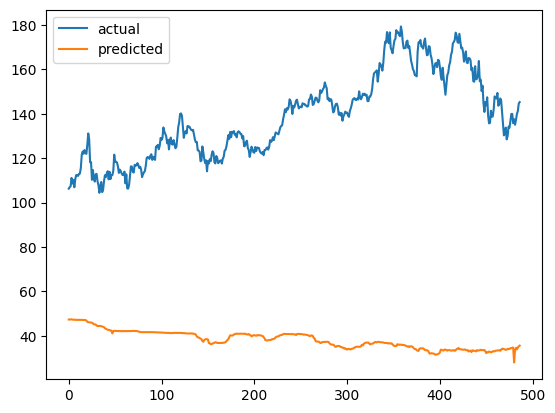

In [250]:
plt.plot(y_test,label = "actual")
plt.plot(y_pred,label = "predicted")
plt.legend()
plt.show()

In [76]:
print(y_test)

[ 1.21000254e-02  1.04688722e-01  2.51977619e-02  6.67811551e-03
  3.62460986e-03  3.48892554e-02 -2.27357560e-02  1.45347177e-02
 -2.97398055e-02  3.32343525e-02  1.76975579e-02 -8.91351266e-04
 -2.61060364e-03  8.33262318e-03  1.25466700e-03  2.21897366e-02
  5.15325703e-02  1.19600878e-02 -8.20363978e-03  1.35990499e-02
 -1.19543784e-02 -1.61992588e-03  3.39121292e-02  3.98324510e-02
 -2.07182902e-02 -8.00607809e-02  6.61867952e-04 -6.72950339e-02
  3.98865826e-02 -3.26457850e-02 -1.31287547e-02  2.99998209e-02
  1.56039392e-03 -2.95137915e-02 -1.59633316e-02 -3.17203445e-02
  3.03258864e-02  1.57156488e-02 -4.19459926e-02  1.02687563e-02
  3.75163092e-02  2.38687104e-02 -7.56786344e-03  1.50758992e-02
  8.46222778e-03 -3.22802814e-02  3.07909963e-02 -2.86694824e-02
  1.69672844e-02 -9.55935518e-04  1.73959183e-02  6.35204530e-02
 -2.65273222e-02  7.43119792e-04 -3.96066316e-03 -1.40004874e-02
 -2.55418671e-02  1.31918049e-02 -5.44619646e-03 -9.58348581e-03
 -6.13401099e-03  8.70691